In [1]:
import sys
from pathlib import Path
import numpy as np
import cv2
import h5py
import pyrealsense2 as rs
import matplotlib.pyplot as plt

In [2]:
!ls ../ |grep ".hdf5"

Vhdf5_20181003_215318.hdf5
Vhdf5_20181020_000453.hdf5
Vhdf5_20181020_040132.hdf5
Vpyrealsense2_20181021_164627.bag.hdf5
pyrealsense2hdf5.py
read_from_file_Vhdf5.py
save_test_Vhdf5.py


In [3]:
def load_hdf5(filepath):
    h5f = h5py.File(filepath, 'r')
    color_frame= h5f['color']
    depth_frame= h5f['depth']
    IR_frame= h5f['IR']
    Total_frame = h5f['color'].shape[0]
    print("Total_frame: %d"%Total_frame)
    return color_frame, depth_frame, IR_frame

In [4]:
color_frame, depth_frame, IR_frame = load_hdf5("../Vhdf5_20181020_000453.hdf5")

Total_frame: 34


In [5]:
i=20

In [6]:
color_image = color_frame[i]
IR_image = IR_frame[i]
depth_image = depth_frame[i]

In [7]:
def cv2singal2rgb(channel):
    return plt.imshow(cv2.applyColorMap(cv2.convertScaleAbs(channel, alpha=0.03), cv2.COLORMAP_JET))



In [8]:
depth_image.dtype

dtype('uint16')

In [9]:
#maping color to rgb format
depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.03), cv2.COLORMAP_JET)
draw_gray_image = cv2.cvtColor(IR_image, cv2.COLOR_GRAY2BGR)

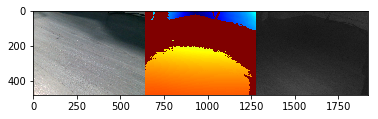

In [10]:
plt.imshow(np.hstack((color_image, depth_colormap, draw_gray_image)))

In [11]:
#pointcloud
#doesn't work
# pc = rs.pointcloud()
# points=rs.points()
# pc.calculate(rs.frame.depth(depth_image))

In [12]:
##2018/10/19 11:35
import scipy.signal
import skimage.util

(-1.9500000000000002, 40.95, -1.4500000000000002, 30.45)

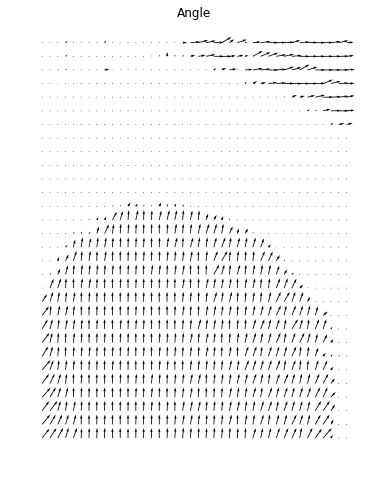

In [13]:
bdx_block = skimage.util.view_as_blocks(np.gradient(depth_image)[1], (16,16))
bdy_block = skimage.util.view_as_blocks(np.gradient(depth_image)[0], (16,16))
bdx_mean = np.mean(bdx_block, axis=(2,3))
bdy_mean = np.mean(bdy_block, axis=(2,3))

plt.figure(figsize=(6,8))
plt.quiver(np.flipud(bdx_mean), np.flipud(bdy_mean))
plt.title("Angle")
plt.axis("off")

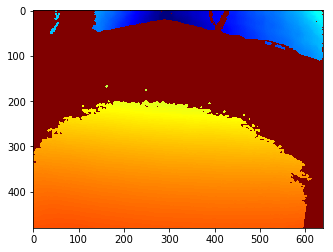

In [14]:
cv2singal2rgb(depth_image)

In [15]:
reverse_depth_image=depth_image[::-1]

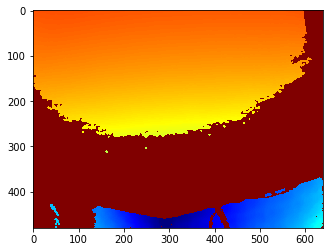

In [16]:
cv2singal2rgb(reverse_depth_image)

In [17]:
print(reverse_depth_image[200,320])
print(reverse_depth_image[120,320])
print(reverse_depth_image[0,320])

2800
2308
1809


In [18]:
#y=mx+c
def twopoint2eq(p1,p2):
    points = [p1,p2]
    x_coords, y_coords = zip(*points)
    A = np.vstack([x_coords,np.ones(len(x_coords))]).T
    m, c = np.linalg.lstsq(A, y_coords)[0]
    print("Line Solution is y = {m}x + {c}".format(m=m,c=c))
    return m,c

In [19]:
qm1,qc1 = twopoint2eq((0,1809),(200,2800))

Line Solution is y = 4.955x + 1809.0


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


In [20]:
qm2,qc2 = twopoint2eq((0,1809),(120,2308))

Line Solution is y = 4.158333333333345x + 1809.0000000000005


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


In [21]:
qm2*240+qc2

2807.000000000003

In [22]:
qm1*120+qc1

2403.6

In [23]:
normal=cv2.pyrUp(cv2.pyrDown(depth_image))

In [24]:
normal.shape

(480, 640)

array([[   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       ...,
       [1752, 1751, 1750, ...,    0,    0,    0],
       [1752, 1751, 1749, ...,    0,    0,    0],
       [1752, 1751, 1749, ...,    0,    0,    0]], dtype=uint16)

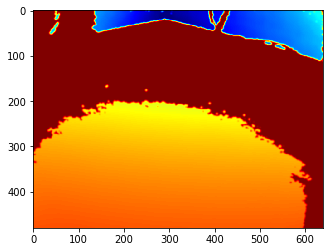

In [25]:
cv2singal2rgb(normal)
normal[200:480]

In [26]:
print(normal[200,320])
print(normal[120,320])
print(normal[0,320])
normal.shape[1]/2

0
0
8186


320.0

In [27]:
##2018/10/20 03:00
from sklearn import linear_model

In [28]:
xaxis = np.array(range(200)).reshape(-1, 1)
yaxis = reverse_depth_image[:200, 320].reshape(-1, 1)

In [29]:
regr = linear_model.LinearRegression()
regr.fit(xaxis, yaxis)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [30]:
xaxis_image = np.array(range(480)).reshape(-1, 1)

In [31]:
predict_x = regr.predict(xaxis_image)
predict_x

array([[1748.35029851],
       [1753.26210455],
       [1758.1739106 ],
       [1763.08571664],
       [1767.99752269],
       [1772.90932873],
       [1777.82113478],
       [1782.73294082],
       [1787.64474687],
       [1792.55655291],
       [1797.46835896],
       [1802.380165  ],
       [1807.29197105],
       [1812.20377709],
       [1817.11558314],
       [1822.02738918],
       [1826.93919523],
       [1831.85100128],
       [1836.76280732],
       [1841.67461337],
       [1846.58641941],
       [1851.49822546],
       [1856.4100315 ],
       [1861.32183755],
       [1866.23364359],
       [1871.14544964],
       [1876.05725568],
       [1880.96906173],
       [1885.88086777],
       [1890.79267382],
       [1895.70447986],
       [1900.61628591],
       [1905.52809195],
       [1910.439898  ],
       [1915.35170404],
       [1920.26351009],
       [1925.17531613],
       [1930.08712218],
       [1934.99892822],
       [1939.91073427],
       [1944.82254031],
       [1949.734

In [32]:
normalize = np.full(reverse_depth_image.shape,predict_x)
normalize

array([[1748.35029851, 1748.35029851, 1748.35029851, ..., 1748.35029851,
        1748.35029851, 1748.35029851],
       [1753.26210455, 1753.26210455, 1753.26210455, ..., 1753.26210455,
        1753.26210455, 1753.26210455],
       [1758.1739106 , 1758.1739106 , 1758.1739106 , ..., 1758.1739106 ,
        1758.1739106 , 1758.1739106 ],
       ...,
       [4091.28178204, 4091.28178204, 4091.28178204, ..., 4091.28178204,
        4091.28178204, 4091.28178204],
       [4096.19358809, 4096.19358809, 4096.19358809, ..., 4096.19358809,
        4096.19358809, 4096.19358809],
       [4101.10539413, 4101.10539413, 4101.10539413, ..., 4101.10539413,
        4101.10539413, 4101.10539413]])

In [33]:
result = reverse_depth_image-normalize
result

array([[ 1.36497015e+01,  7.64970149e+00,  3.64970149e+00, ...,
        -1.74835030e+03, -1.74835030e+03, -1.74835030e+03],
       [ 2.73789545e+00, -1.26210455e+00, -5.26210455e+00, ...,
        -1.75326210e+03, -1.75326210e+03, -1.75326210e+03],
       [-8.17391060e+00, -8.17391060e+00, -1.01739106e+01, ...,
        -1.75817391e+03, -1.75817391e+03, -1.75817391e+03],
       ...,
       [-4.09128178e+03, -4.09128178e+03, -4.09128178e+03, ...,
        -4.09128178e+03, -4.09128178e+03, -4.09128178e+03],
       [-4.09619359e+03, -4.09619359e+03, -4.09619359e+03, ...,
        -4.09619359e+03, -4.09619359e+03, -4.09619359e+03],
       [-4.10110539e+03, -4.10110539e+03, -4.10110539e+03, ...,
        -4.10110539e+03, -4.10110539e+03, -4.10110539e+03]])

In [34]:
normalized = np.where((result<1000)&(result>0),result,0)

192.0

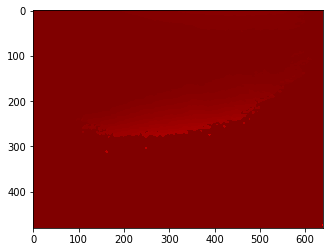

In [35]:
cv2singal2rgb(normalized)
normalized.shape[0]/2.5

In [36]:
from sklearn import linear_model
def depth2normalize1(image,y_line_end = 0):
    if(y_line_end == 0):
        y_line_end = int(image.shape[0]/2.5)
    image_reverse = image[::-1]
    image_middle_x = int(image_reverse.shape[1]/2)
    x_train = np.array(range(y_line_end)).reshape(-1, 1)
    y_train = image_reverse[:y_line_end, image_middle_x].reshape(-1, 1)
    
    equation = linear_model.LinearRegression().fit(x_train, y_train)
    x_predict = np.array(range(image_reverse.shape[0])).reshape(-1, 1)
    y_predict = equation.predict(x_predict)
    normalize_matrix = np.full(reverse_depth_image.shape,y_predict)[::-1]
    return normalize_matrix

def apply_normalize_matrix(image, matrix):
    normalized = (image - matrix)
    return np.where((normalized<1000)&(normalized>0),normalized,0)

In [37]:
from sklearn.svm import SVR
def depth2normalizeSVR(image,y_line_end = 0):
    if(y_line_end == 0):
        y_line_end = int(image.shape[0]/2.5)
    image_reverse = image[::-1]
    image_middle_x = int(image_reverse.shape[1]/2)
    x_train = np.array(range(y_line_end)).reshape(-1, 1)
    y_train = image_reverse[:y_line_end, image_middle_x]
    ##
    svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
    x_predict = np.array(range(image_reverse.shape[0])).reshape(-1, 1)
    y_predict = svr_rbf.fit(x_train, y_train).predict(x_predict).reshape(-1, 1)
    normalize_matrix = np.full(reverse_depth_image.shape,y_predict)[::-1]
    return normalize_matrix

In [38]:
from scipy.optimize import curve_fit
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

def depth2normalize(image,y_line_end = 0):
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(121)
    ax2 = fig1.add_subplot(122)
    if(y_line_end == 0):
        y_line_end = int(image.shape[0]/2.5)
    image_reverse = image[::-1]
    image_middle_x = int(image_reverse.shape[1]/2)
    x_train = np.array(range(y_line_end))
    y_train = image_reverse[:y_line_end, image_middle_x]
    image = np.full((y_line_end,100),y_train.reshape(-1, 1))
    ax2.imshow(cv2.applyColorMap(cv2.convertScaleAbs(image, alpha=0.03), cv2.COLORMAP_JET))
    ax1.plot(x_train[:50], y_train[:50])
    ##
    popt, pcov = curve_fit(func, x_train, y_train)
    x_predict = np.array(range(image_reverse.shape[0]))
    y_predict = func(x_predict, *popt)
    print(y_train)
    ax1.plot(x_predict[:50], y_predict[:50])
    normalize_matrix = np.full(image_reverse.shape,y_predict.reshape(-1, 1))[::-1]
    return normalize_matrix



[1810 1811 1812 1814 1817 1820 1823 1827 1830 1834 1837 1841 1844 1848
 1851 1855 1858 1862 1865 1869 1873 1877 1881 1885 1889 1893 1896 1899
 1902 1905 1909 1913 1918 1923 1928 1932 1936 1939 1942 1945 1949 1953
 1958 1962 1966 1970 1974 1978 1982 1986 1990 1994 1998 2002 2006 2009
 2013 2016 2020 2024 2028 2032 2036 2040 2045 2050 2054 2059 2063 2068
 2073 2078 2082 2086 2089 2093 2097 2102 2107 2111 2116 2121 2126 2130
 2135 2140 2145 2150 2154 2158 2162 2166 2170 2174 2178 2182 2187 2192
 2198 2203 2209 2214 2219 2224 2229 2233 2238 2243 2248 2253 2258 2262
 2267 2272 2278 2283 2288 2293 2298 2303 2308 2312 2317 2322 2328 2334
 2340 2345 2351 2356 2361 2366 2372 2378 2383 2389 2395 2402 2408 2414
 2419 2424 2429 2434 2439 2445 2451 2457 2463 2469 2475 2481 2487 2492
 2497 2502 2509 2515 2521 2527 2533 2539 2546 2553 2561 2569 2576 2582
 2588 2593 2599 2604 2610 2615 2622 2629 2637 2644 2651 2657 2663 2669
 2676 2682 2689 2696 2703 2710 2717 2723 2730 2736 2743 2750 2758 2766
 2773 

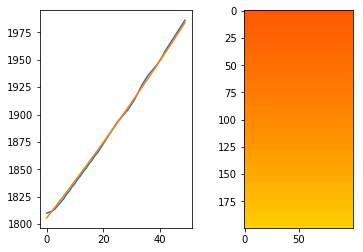

In [39]:
normalized_depth = depth2normalize(normal,200)

array([6356.50452387, 6335.77200462, 6315.11891806, 6294.54495986,
       6274.04982685, 6253.63321703, 6233.29482955, 6213.03436472,
       6192.85152399, 6172.74600996, 6152.71752637, 6132.76577809,
       6112.89047113, 6093.0913126 , 6073.36801078, 6053.72027502,
       6034.1478158 , 6014.65034473, 5995.22757449, 5975.87921889,
       5956.60499282, 5937.40461227, 5918.2777943 , 5899.22425709,
       5880.24371987, 5861.33590295, 5842.50052773, 5823.73731664,
       5805.04599322, 5786.42628203, 5767.87790872, 5749.40059995,
       5730.99408346, 5712.65808803, 5694.39234346, 5676.1965806 ,
       5658.07053134, 5640.01392857, 5622.02650622, 5604.10799926,
       5586.25814363, 5568.47667631, 5550.76333529, 5533.11785955,
       5515.53998909, 5498.02946487, 5480.58602889, 5463.20942411,
       5445.89939446, 5428.65568489, 5411.4780413 , 5394.36621057,
       5377.31994056, 5360.33898007, 5343.42307889, 5326.57198775,
       5309.78545836, 5293.06324334, 5276.4050963 , 5259.81077

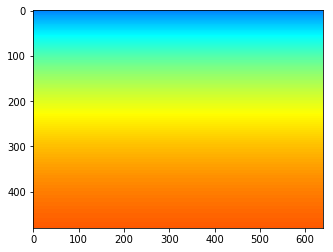

In [40]:
cv2singal2rgb(normalized_depth)
normalized_depth[:,0]

In [41]:
color_frame, depth_frame, IR_frame = load_hdf5("../Vhdf5_20181020_040132.hdf5")


Total_frame: 67


In [42]:
depth_image1 = depth_frame[0]
depth_image2 = depth_frame[50]

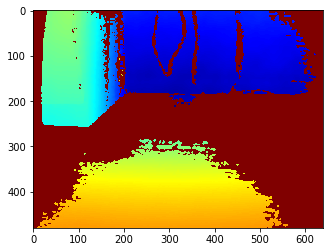

In [43]:
cv2singal2rgb(depth_image1)

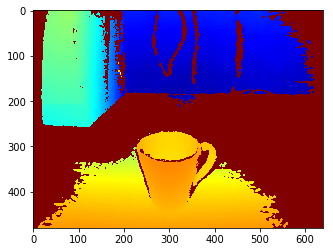

In [44]:
cv2singal2rgb(depth_image2)

[1809 1810 1812 1814 1816 1820 1823 1827 1830 1834 1837 1841 1844 1848
 1852 1855 1858 1862 1865 1869 1873 1877 1881 1885 1889 1893 1896 1900
 1902 1905 1908 1912 1918 1923 1928 1932 1936 1939 1942 1945 1948 1952
 1957 1962 1966 1970 1974 1978 1982 1986 1990 1994 1998 2002 2006 2010
 2013 2016 2020 2024 2028 2032 2036 2040 2045 2050 2054 2059 2063 2068
 2073 2078 2082 2086 2090 2093 2097 2102 2106 2112 2116 2121 2126 2130
 2135 2140 2145 2150 2154 2158 2162 2166 2170 2174 2178 2182 2186 2191
 2197 2203 2209 2214 2220 2224 2228 2233 2238 2244 2248 2253 2257 2261
 2266 2272 2278 2283 2288 2293 2298 2303 2308 2312 2317 2322 2328 2334
 2340 2346 2351 2356 2361 2366 2372 2378 2384 2389 2395 2402 2408 2414
 2419 2424 2429 2434 2439 2445 2452 2457 2463 2468 2475 2481 2486 2492
 2497 2502 2508 2515 2521 2527 2532 2538 2546 2553 2562 2570 2577 2583
 2588 2593 2598 2604 2609 2615 2621 2629 2638 2645 2651 2656 2662 2668
 2675 2682 2689 2696 2704 2711 2718 2724]


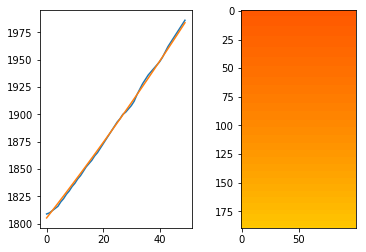

In [45]:
normalize_matrix = depth2normalize(depth_image,190).astype(np.int32)

In [46]:
depth_image2_32 = depth_image2.astype(np.int32)
depth_image1_32 = depth_image1.astype(np.int32)

In [47]:
normalised = (normalize_matrix - depth_image2)

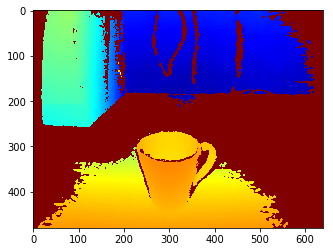

In [48]:
cv2singal2rgb(depth_image2)

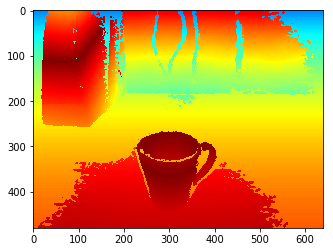

In [49]:
cv2singal2rgb(normalised)

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

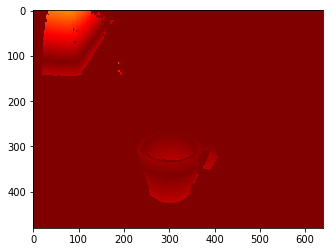

In [50]:
normalised = (normalize_matrix - depth_image2)
MASKED = np.where((depth_image2==0)|(normalised<-500),0,normalised)
cv2singal2rgb(MASKED)
np.max(MASKED)
MASKED[:,300]

array([ 64,  72,  81,  89,  97, 105, 113, 121, 129, 137, 145, 154, 162,
       171, 178, 186, 195, 202, 210, 218, 226, 234, 242, 250, 257, 266,
       273, 280, 289, 297, 304, 312, 320, 328, 336, 344, 352, 359, 367,
       374, 382, 389, 397, 405, 412, 419, 425, 432, 438, 445,   0,   0,
         0,   0, 250, 244, 237, 231, 225, 218, 211, 203, 195, 187, 178,
       170, 162, 153, 144, 136, 129, 119, 112, 103,  95,  87,  78,  69,
        61,  53,  43,  35,  27,  19,  11,   2,   6,  15,  24,  32,  40,
        49,  57,  65,  74,  82,  90,  98, 107, 115, 123, 131, 139, 146,
       154, 163, 172, 180, 189, 198, 206, 215, 224, 232, 241, 249, 258,
       267, 276, 284, 293, 301, 310, 318, 327, 334, 342, 351, 359, 369,
       378, 386, 393, 402, 410, 419, 427, 436, 444, 452, 461, 470, 480,
       488, 497,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

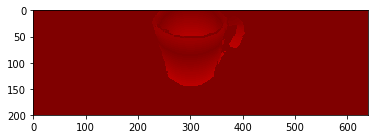

In [51]:
cv2singal2rgb(MASKED[-200:])
np.abs(MASKED[-200:,300])

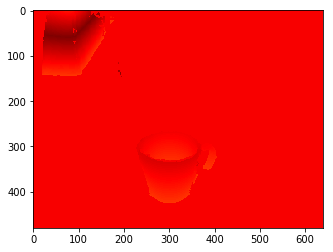

In [52]:
cv2singal2rgb(np.abs(MASKED-1000))

In [53]:
MASKED[-200:,200].shape

(200,)

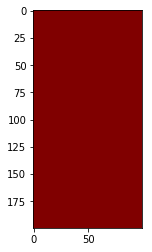

In [54]:
cv2singal2rgb(np.full((200,100),MASKED[-200:,200][:,np.newaxis]))

In [55]:
MASKED[:,200]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

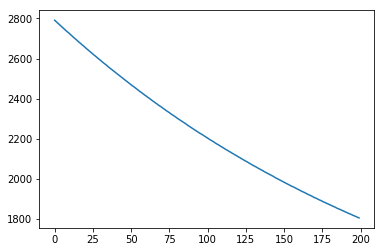

In [56]:
plt.plot(normalize_matrix[-200:,0])

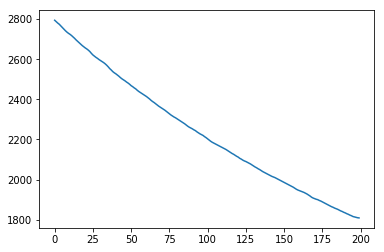

In [57]:
plt.plot(depth_image[-200:,320])

In [58]:
depth_image1 = depth_image1.astype(np.int32)
depth_image2 = depth_image2.astype(np.int32)
np.abs((depth_image1-depth_image2))[-200:,320]

array([2841, 2842, 2842, 2842, 2843, 2844, 2844, 1558, 1554, 1551, 1539,
       1532, 1523, 1518, 1515, 2853, 2854, 2856, 1423, 1399, 1394, 1391,
       1387, 1384, 1377, 2867, 2868, 2870, 1179, 1169, 1163, 1152, 1141,
       1133, 1126, 2881, 2883, 1021, 1006,  996,  986,  972,  956,  942,
        929,  916,  903,  888,  871,  854, 3740, 3730, 3724, 3718, 1498,
       1487, 1471, 1452, 1431, 1414, 1398, 1382, 1367, 1352, 1339, 1324,
       1312, 1298, 1286, 1272, 1254, 1233, 1208, 1184, 1160, 1142, 1130,
       1123, 1116, 1112, 1104, 1095, 1082, 1068, 1054, 1040, 1025, 1008,
        991,  973,  957,  942,  927,  909,  893,  876,  861,  847,  834,
        822,  808,  794,  778,  764,  751,  738,  725,  713,  704,  692,
        680,  667,  653,  638,  623,  610,  598,  588,  578,  567,  556,
        542,  530,  516,  504,  489,  473,  456,  440,  427,  416,  406,
        397,  386,  374,  360,  346,  333,  321,  310,  299,  287,  277,
        265,  253,  242,  228,  214,  200,  187,  1

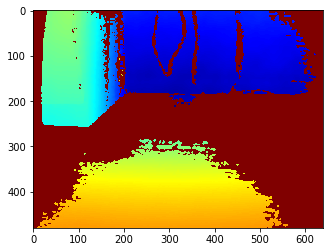

In [59]:
cv2singal2rgb(depth_image1)

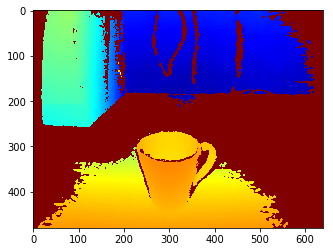

In [60]:
cv2singal2rgb(depth_image2)

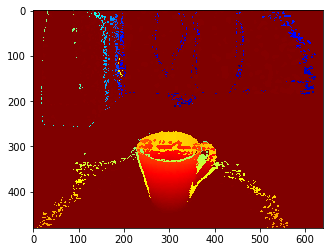

In [64]:
subtruct=(np.abs(depth_image1-depth_image2))
subtruct = cv2.applyColorMap(cv2.convertScaleAbs(subtruct, alpha=0.03), cv2.COLORMAP_JET)
plt.imshow(subtruct)

In [62]:
cv2.imshow('asd',(cv2.Canny(subtruct,40,50)))

In [63]:
cv2.imshow('masked',masked)

NameError: name 'masked' is not defined

In [ ]:
plt.plot(depth_image1[400])